## Logistic Regression && XGBoost Model

A logistic regression model is a type of statistical model used for binary classification tasks. Unlike linear regression, which predicts a continuous outcome, logistic regression predicts the probability of a binary outcome (i.e., a categorical outcome with two possible values such as 0/1, true/false, yes/no).

XGBoost (eXtreme Gradient Boosting) is an optimized and scalable implementation of gradient boosting, a machine learning technique used for classification and regression tasks. It is designed to be efficient, flexible, and portable, offering a range of enhancements over traditional gradient boosting techniques, such as regularization, parallel processing, and handling missing values.

In [ ]:
%pip install polars
%pip install pyarrow
%pip install imbalanced-learn
%pip install xgboost
%pip install imbalanced-learn

In [92]:
#import necessary libraries
import sys
import pyarrow
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import cm
import numpy as np
import polars as pl
import pandas as pd
from glob import glob
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import learning_curve
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from random import randint, uniform

import warnings
warnings.filterwarnings('ignore')
# Append the directory containing `merge_tools.py` to the Python path
sys.path.append('../notebooks/utils/')

In [4]:
# Importing functions from merge_tools.py
def merge_n_case_ids(
    n_ids: int = 10000,
    data_dir: str = '/kaggle/input/cr-newagg/new_aggs',
    path_to_base: str = '/kaggle/input/datasets-cr/train_base.parquet',
    use_0: bool = True,
    as_pandas: bool = True,
    random_state: int = 28
) -> pl.DataFrame | pd.DataFrame:
    '''
    Function to merge selected case_id from parquet files, returns subset case_id from the merged dataset.

    Parameters
    ----------
    n_ids : Number of case_ids to sample initially and return (int)
    data_dir : Path to processed parquet files directory (str)
    path_to_base : Path to base file (str)
    use_0 : Use num_group1 == 0 (bool)
    as_pandas : Return as pandas DataFrame
    random_seed : Random seed (int)
    '''
    # Read the base dataframe and sample case_ids
    if as_pandas:
        base_df = pd.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, random_state=random_state).tolist()
    else:
        base_df = pl.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, seed=random_state).to_list()

    # Define the file pattern for fetching files
    file_pattern = '*grouped_0.parquet' if use_0 else '*grouped_rest.parquet'
    file_paths = glob(data_dir + '/' + file_pattern)

    # Initialize the merged DataFrame filtering the base DataFrame
    if as_pandas:
        df = base_df[base_df['case_id'].isin(case_ids)]
    else:
        df = base_df.filter(pl.col('case_id').is_in(case_ids))

    # Merge DataFrames with only the selected case_ids
    for path in file_paths:
        if as_pandas:
            temp = pd.read_parquet(path)
            temp = temp[temp['case_id'].isin(case_ids)]
            df = pd.merge(df, temp, on='case_id', how='outer')
        else:
            temp = pl.read_parquet(path)
            temp = temp.filter(pl.col('case_id').is_in(case_ids))
            df = df.join(temp, on='case_id', how='outer')

    # Convert to pandas if required and using Polars
    if as_pandas and isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    return df

In [5]:
# Setting up the file paths and parameters
base_path = '../data/raw/parquet_files/train/train_base.parquet'
data_dir = '../data/processed/grouped/new_aggs/'

# Choose parameters
n_ids = 20000  # let's start by processing only 20000 case_ids
use_0 = True  
as_pandas = True  # Return result as pandas DataFrame
random_state=28 


The merge_n_case_ids function merges data from multiple files based on the provided IDs, optionally includes a base file, and returns the merged data in the desired format 

In [6]:
# Merge data function
merged_data = merge_n_case_ids(
    n_ids=n_ids, 
    data_dir=data_dir, 
    path_to_base=base_path, 
    use_0=use_0, 
    as_pandas=as_pandas)


In [7]:
#Inspect the merged dataset
merged_data

,case_id,date_decision,MONTH,WEEK_NUM,target,empls_employedfrom_796D_distinct,empls_employedfrom_796D_min_year,empls_employedfrom_796D_min_month,empls_employedfrom_796D_min_day,empls_employedfrom_796D_max_year,...,amtdebitincoming_4809443A_median,amtdebitoutgoing_4809440A_median,amtdepositbalance_4809441A_median,amtdepositincoming_4809444A_median,amtdepositoutgoing_4809442A_median,amtdebitincoming_4809443A_sum,amtdebitoutgoing_4809440A_sum,amtdepositbalance_4809441A_sum,amtdepositincoming_4809444A_sum,amtdepositoutgoing_4809442A_sum
0,4,2019-01-04,201901,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,134,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,287,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,360,2019-01-05,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2703286,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,20000.0,20000.0,0.0000,0.0,0.0,20000.0,20000.0,0.0000,0.0,0.0
19996,2703347,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19997,2703348,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19998,2703350,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,4442.8003,0.0,35.8,0.0,0.0,4442.8003,0.0,35.8


## Data Cleaning on the Preprocessed Data

In [20]:
# Converting 'date_decision' from object to 'datetime64'
merged_data['date_decision'] = pd.to_datetime(merged_data['date_decision'])

# Get boolean columns from df_full
bool_columns = merged_data.select_dtypes(include=['bool']).columns.tolist()

for col in bool_columns:
    merged_data[col] = merged_data[col].fillna(False).astype(bool)

# Get object columns from df_full
object_columns = merged_data.select_dtypes(include=['object']).columns.tolist()

for col in object_columns:
    merged_data[col] = merged_data[col].replace({None: np.nan, True: 1.0, False: 0.0})

# Display the DataFrame to see the changes
print(merged_data)

       case_id date_decision   MONTH  WEEK_NUM  target  \
0            4    2019-01-04  201901         0       1   
1          134    2019-01-04  201901         0       0   
2          199    2019-01-04  201901         0       0   
3          287    2019-01-04  201901         0       0   
4          360    2019-01-05  201901         0       0   
...        ...           ...     ...       ...     ...   
19995  2703286    2020-10-05  202010        91       0   
19996  2703347    2020-10-05  202010        91       0   
19997  2703348    2020-10-05  202010        91       0   
19998  2703350    2020-10-05  202010        91       0   
19999  2703352    2020-10-05  202010        91       0   

       empls_employedfrom_796D_distinct  empls_employedfrom_796D_min_year  \
0                                   NaN                               NaN   
1                                   1.0                               NaN   
2                                   1.0                               Na

In [21]:
merged_data.drop(columns='date_decision', inplace=True)

### Removing Columns that have more than 95% of their data missing

In [22]:
# Remove columns with more than 95% missing values
missing_threshold = 0.95
merged_data_filtered = merged_data.loc[:, merged_data.isnull().mean() < missing_threshold]

In [23]:
merged_data_filtered 

,case_id,MONTH,WEEK_NUM,target,empls_employedfrom_796D_distinct,addres_district_368M_freq,addres_zip_823M_freq,conts_role_79M_freq,empls_economicalst_849M_freq,empls_employer_name_740M_freq,...,rejectreasonclient_4145042M_binary_1,rejectreasonclient_4145042M_binary_2,rejectreasonclient_4145042M_binary_3,status_219L_binary_0,status_219L_binary_1,status_219L_binary_2,status_219L_binary_3,date_decision_year,date_decision_month,date_decision_day
0,4,201901,0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2019,1,4
1,134,201901,0,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,4
2,199,201901,0,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,4
3,287,201901,0,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,4
4,360,201901,0,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2703286,202010,91,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2020,10,5
19996,2703347,202010,91,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2020,10,5
19997,2703348,202010,91,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2020,10,5
19998,2703350,202010,91,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2020,10,5


## Train and Validation Split
### Missing Values Imputation
### Model Building

In [24]:
# Initial split to separate out the test dataset
df_train, df_test = train_test_split(merged_data_filtered, test_size=0.2, random_state=1)

# Initial split to separate out the test dataset
df_train, df_test = train_test_split(merged_data_filtered, test_size=0.2, random_state=1)

# Get features and target
X_test = df_test.drop(columns=["case_id", "WEEK_NUM", "target"])
y_test = df_test["target"]

X = df_train.drop(columns=["case_id", "WEEK_NUM", "target"])
y = df_train["target"]

#  Train and Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=1, stratify=y)

In [25]:
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)

X_train shape: (11200, 1008)
X_valid shape: (4800, 1008)


### Imputation with Mean and Binary flag Indicator for missing values.

In [59]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed = X_train.copy()
X_valid_imputed = X_valid.copy()
X_test_imputed = X_test.copy()


# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed[col + '_missing'] = X_train_imputed[col].isnull().astype(int)
    X_valid_imputed[col + '_missing'] = X_valid_imputed[col].isnull().astype(int)
    X_test_imputed[col + '_missing'] = X_test_imputed[col].isnull().astype(int)

# Impute missing values with mean
mean_imputer = SimpleImputer(strategy='mean')
X_train_imputed[numerical_columns] = mean_imputer.fit_transform(X_train_imputed[numerical_columns])
X_valid_imputed[numerical_columns] = mean_imputer.transform(X_valid_imputed[numerical_columns])
X_test_imputed[numerical_columns] = mean_imputer.transform(X_test_imputed[numerical_columns])

print("Missing values in X_train_imputed:")
print(X_train_imputed.isnull().sum())

print("\nMissing values in X_valid_imputed:")
print(X_valid_imputed.isnull().sum())

print("\nMissing values in X_test_imputed:")
print(X_test_imputed.isnull().sum())

Missing values in X_train_imputed:
MONTH                               0
empls_employedfrom_796D_distinct    0
addres_district_368M_freq           0
addres_zip_823M_freq                0
conts_role_79M_freq                 0
                                   ..
status_219L_binary_2_missing        0
status_219L_binary_3_missing        0
date_decision_year_missing          0
date_decision_month_missing         0
date_decision_day_missing           0
Length: 2016, dtype: int64

Missing values in X_valid_imputed:
MONTH                               0
empls_employedfrom_796D_distinct    0
addres_district_368M_freq           0
addres_zip_823M_freq                0
conts_role_79M_freq                 0
                                   ..
status_219L_binary_2_missing        0
status_219L_binary_3_missing        0
date_decision_year_missing          0
date_decision_month_missing         0
date_decision_day_missing           0
Length: 2016, dtype: int64

Missing values in X_test_imputed:
MONT

### Model Evaluation after data imputation

In [60]:
# Function to evaluate and print metrics
def evaluate_model(name, y_true, y_pred, y_pred_probs):
    auc_score = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {name} ---")
    print(f"AUC: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

In [64]:
model_mean = XGBClassifier(random_state=1)
# Fit the model
model_mean.fit(X_train_imputed, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_imputed)[:, 1]
y_valid_pred = model_mean.predict(X_valid_imputed)

# Evaluate the model
name='XGBClassifer with NaN Imputer Median Simple Imputer and Binary Flag'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)


--- XGBClassifer with NaN Imputer Median Simple Imputer and Binary Flag ---
AUC: 0.6816
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9663
F1 Score: 0.0000



### Conclusions:

The model's high accuracy is likely misleading due to class imbalance, where the negative class dominates. This results in the model predicting the majority class (negative) most of the time.
The very low precision, recall, and F1 score indicate that the model is not performing well in identifying the positive class. This is due to the severe class imbalance.

## Data Standarization and Dimensionality Reduction

Applying StandardScaler which standardizes the features of the training and validation datasets to have zero mean and unit variance based on the statistics (mean and standard deviation) of the training data.

#### Logistic Regression and XGBoost model approaches

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_valid_scaled = scaler.transform(X_valid_imputed)

In [66]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('imputer', mean_imputer),
    ('logistic', LogisticRegression(solver='saga', random_state=42))
])

In [67]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],  # Number of components to keep
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strengths
}

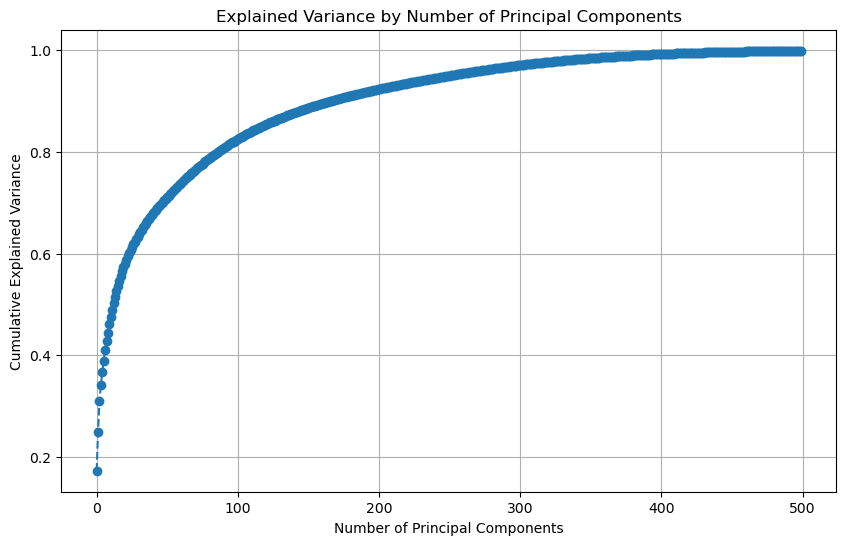

In [68]:
# Apply PCA on scaled and reduced training data
pca = PCA(n_components=500)  # Adjust n_components as needed
X_train_reduced_pca = pca.fit_transform(X_train_scaled)
X_valid_reduced_pca = pca.transform(X_valid_scaled)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

In [70]:
# Set up grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_reduced_pca, y_train)  # Train the model with grid search

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('imputer', SimpleImputer()),
                                       ('logistic',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             param_grid={'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'pca__n_components': [5, 10, 15, 20, 25, 30]},
             scoring='roc_auc', verbose=1)

Validation AUC: 0.671
Precision: 0.000
Recall: 0.000
Accuracy: 0.967
F1 Score: 0.000
Confusion Matrix:
[[4641    1]
 [ 158    0]]


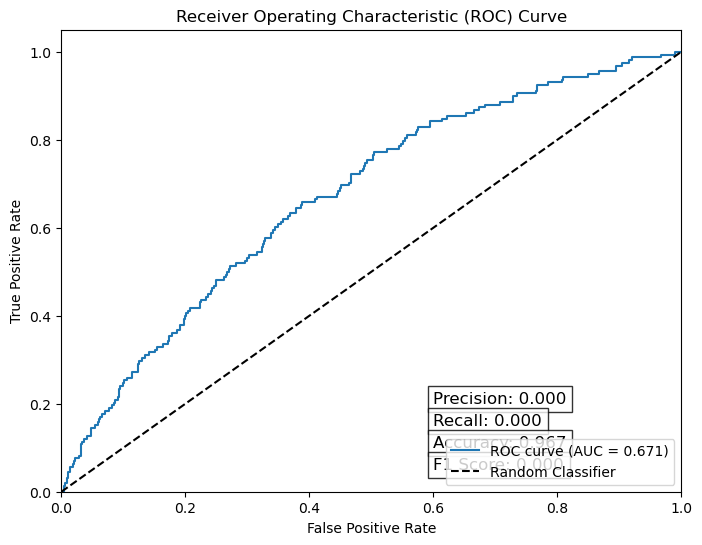

In [37]:
# Predict probabilities on the validation set
y_pred_prob = grid_search.best_estimator_.predict_proba(X_valid_reduced_pca)[:, 1]

# Compute AUC
auc_score = roc_auc_score(y_valid, y_pred_prob)
print(f"Validation AUC: {auc_score:.3f}")

# Adjust the classification threshold to 0.3 
threshold = 0.3
y_pred = (y_pred_prob >= threshold).astype(int)

# Compute precision, recall, accuracy, and F1 score
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
accuracy = accuracy_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Add metrics to the plot
plt.text(0.6, 0.2, f'Precision: {precision:.3f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.6, 0.15, f'Recall: {recall:.3f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.6, 0.1, f'Accuracy: {accuracy:.3f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.6, 0.05, f'F1 Score: {f1:.3f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

In [71]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'logistic__C': 100, 'pca__n_components': 30}


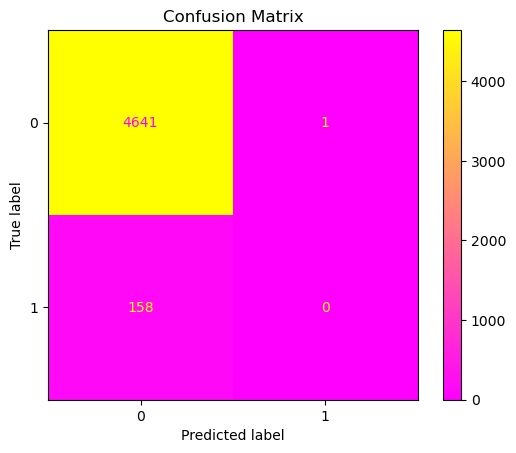

Best parameters found: {'logistic__C': 100, 'pca__n_components': 30}
Accuracy: 96.69%


In [72]:
# Predict class labels on the validation set
y_pred = grid_search.best_estimator_.predict(X_valid_reduced_pca)

# Generate and display the confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.spring)  # Changed color map to 'viridis'
plt.title('Confusion Matrix')
plt.show()

# Output the best parameters
print("Best parameters found:", grid_search.best_params_)

# Calculate and print the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy:.2%}")  # Printing as a percentage


## Findings
The model shows a high accuracy of 96.7%, which can be misleading in the presence of imbalanced classes.
The low precision, recall, and F1 score indicate poor performance in detecting the minority class.
This is further evidenced by the confusion matrix, which shows a significant number of false negatives.

In [73]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
    title : string, title of the chart
    X : array-like, shape (n_samples, n_features), training vector
    y : array-like, shape (n_samples) or (n_samples, n_features), target values
    ylim : tuple, shape (ymin, ymax), Defines minimum and maximum yvalues plotted
    cv : int, cross-validation generator or an iterable
    n_jobs : int or None, optional (default=None), number of jobs to run in parallel
    train_sizes : array-like, shape (n_ticks,), percentage of training instances to generate learning curve
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-pack

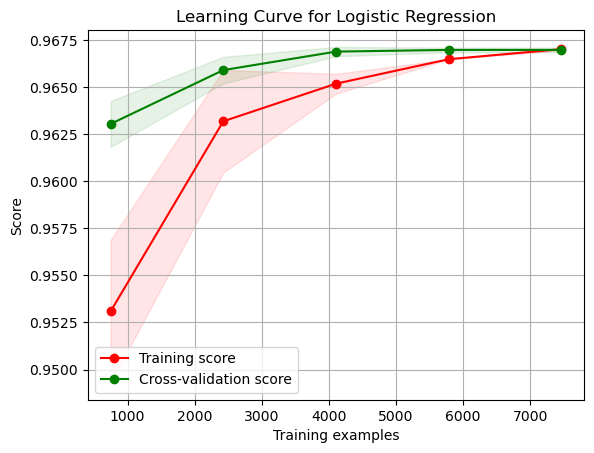

In [74]:
# Use the best estimator from your previous grid search
best_estimator = grid_search.best_estimator_

# Generate the learning curve
plot_learning_curve(estimator=best_estimator, title='Learning Curve for Logistic Regression',
                    X=X_train_reduced_pca, y=y_train, cv=3, n_jobs=-1)

# Show plot
plt.show()


### Initialize and Train the XGBoost Model and applying SMOTE
Train the XGBoost model using the training data:

In [95]:
# Define the pipeline for XGBoost
pipeline = ImbPipeline([
    ('imputer', mean_imputer),
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('pca', PCA()),  # You can specify the number of components if needed
    ('xgboost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, tree_method='gpu_hist', predictor='gpu_predictor'))
])

### Findings:
The confusion matrix shows a high number of true negatives (5793) compared to a very low number of true positives (3), indicating that the dataset is highly imbalanced. There are significantly more instances of the negative class than the positive class.

The high accuracy (0.966) is misleading because it is primarily due to the model's ability to correctly predict the negative class. The model is not effectively capturing the positive class, as evidenced by the very low recall (0.015).

You used a default threshold of 0.3 to classify the positive class. Despite this, the recall is still very low, suggesting that the model needs better calibration or more sophisticated handling of the class imbalance.

Therefore lets try hyperparameter tuning to see how well the model gets

### Hyperparameter Tuning

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   5.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  11.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  11.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estima

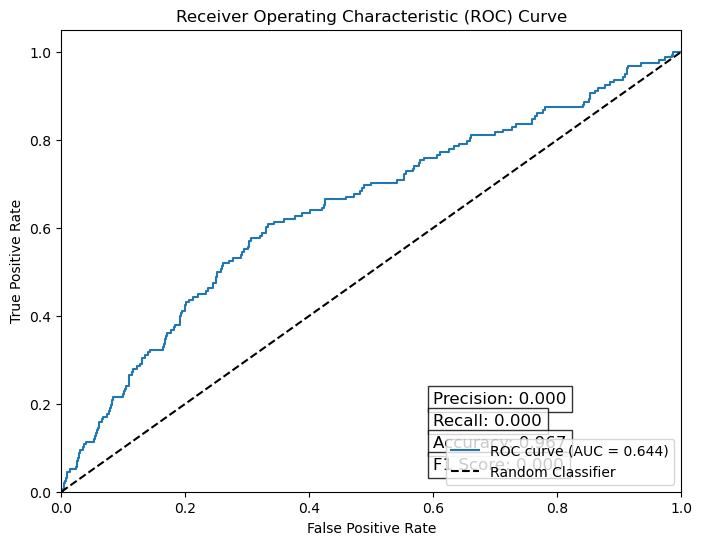

In [98]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train_reduced_pca, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

# Use the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_prob = best_xgb_model.predict_proba(X_valid_reduced_pca)[:, 1]
auc_score = roc_auc_score(y_valid, y_pred_prob)
print(f"Validation AUC: {auc_score:.3f}")

threshold = 0.3
y_pred = (y_pred_prob >= threshold).astype(int)

# Compute precision, recall, accuracy, and F1 score
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
accuracy = accuracy_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.text(0.6, 0.2, f'Precision: {precision:.3f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.6, 0.15, f'Recall: {recall:.3f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.6, 0.1, f'Accuracy: {accuracy:.3f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.6, 0.05, f'F1 Score: {f1:.3f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

### Findings:
Class Imbalance:

The results indicate that the dataset is highly imbalanced. The model is biased towards the negative class due to the imbalance, which is evident from the high number of true negatives and the very low number of true positives.
High Accuracy but Low Recall:

The high accuracy is misleading as it primarily comes from correctly predicting the majority class. The model's recall is very low, indicating that it fails to capture the positive instances effectively.
Improved AUC:

The AUC has improved to 0.644, suggesting that the model's ability to distinguish between classes has improved with hyperparameter tuning.
Low Precision and F1 Score:

The low precision and F1 score indicate that the model's positive predictions are not reliable. It is making too many false positive predictions, and the overall balance between precision and recall is poor.